<a href="https://colab.research.google.com/github/InesFaria-UM/DataScience4Covid19/blob/main/DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

For this workflow it will be necessary import the following packages:

In [ ]:
import os
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib as plt
import keras
from tensorflow.keras import layers, callbacks
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras import regularizers
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from tensorflow.keras.layers import InputLayer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore') 

import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2

Before starting the development of the predictive models, we proceeded to extract the dataset, directly from Kaggle.

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
!kaggle datasets download -d darshan1504/covid19-detection-xray-dataset

 90% 168M/186M [00:01<00:00, 161MB/s]
100% 186M/186M [00:01<00:00, 167MB/s]


In [ ]:
ls

kaggle.json  NonAugmentedTrain/  TrainData/  ValData/


In [ ]:
!unzip \*.zip  && rm *.zip;

Initially the pixel values of the images that will be used for training and testing were scaled in the range from [0,255] to [0,1] interval. 

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

Furtherly, batches of tensor image data are generated with real-time data augmentation

In [ ]:
train_generator = train_datagen.flow_from_directory(
        '/content/gdrive/My Drive/Kaggle/TrainData',
        target_size=(384, 384),
        batch_size=32,
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        '/content/gdrive/My Drive/Kaggle/ValData',
        target_size=(384, 384),
        batch_size=32,
        class_mode='categorical')

Found 2023 images belonging to 4 classes.
Found 988 images belonging to 4 classes.


Now, it is possible to visualize some examples of x-ray images of each class, Covid, Bacterial, Viral Pneumonia and Healthy patients.

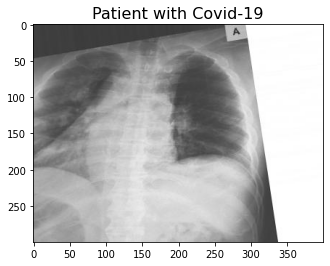

In [ ]:
covid = cv2.imread("/content/gdrive/My Drive/Kaggle/TrainData/COVID-19/_0_1465610.jpeg")
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.titlesize"] = 16
plt.title("Patient with Covid-19")
plt.imshow(covid);

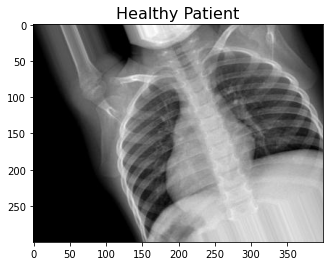

In [ ]:
Normal = cv2.imread("/content/gdrive/My Drive/Kaggle/TrainData/Normal/_0_6256933.jpeg")
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.titlesize"] = 16
plt.title("Healthy Patient")
plt.imshow(Normal);

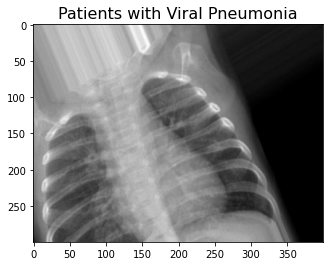

In [ ]:
viral = cv2.imread("/content/gdrive/My Drive/Kaggle/TrainData/ViralPneumonia/_0_9503218.jpeg")
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.titlesize"] = 16
plt.title("Patients with Viral Pneumonia")
plt.imshow(viral);

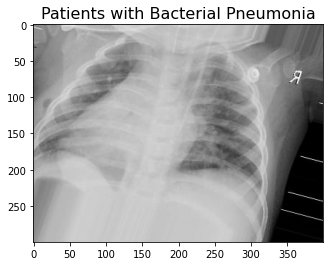

In [ ]:
bacterial = cv2.imread("/content/gdrive/My Drive/Kaggle/TrainData/BacterialPneumonia/_0_4754176.jpeg")
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.titlesize"] = 16
plt.title("Patients with Bacterial Pneumonia")
plt.imshow(bacterial);

When building the Convolutional Neural Network, the Sequential function was used, which allows the construction of linear stacked layers, being possible to treat each layer as an object that feeds data to the next one. 
The first layer is always convolutional. The input size consists at 384x384x3 array of pixel values, where 3 is RGB-related and this feature map is passed through an activation layer, ReLU. 
Then the building of the pooling layer starts. This layer consists in reducing the dimensionality of each feature map by retaining the most important information.
Finally, we flatten the feature map into 1D, to be introduced in a Fully Connected Layer with a final output that has 4 neurons which is the number of classes. 

-----

The following models were subjected to different parameters upon construction, furthermore we also used different methods for overfitting prevention.

## First Model

In [ ]:
model1 = Sequential()

model1.add(Conv2D(16, (3,3), input_shape=(384,384,3), activation = "relu"))
model1.add(Conv2D(32, (3,3), activation = "relu"))
model1.add(Conv2D(64, (3,3), activation = "relu"))

model1.add(MaxPool2D(2,2))
model1.add(MaxPool2D(2,2))
model1.add(MaxPool2D(2,2))

model1.add(Flatten())
model1.add(Dropout(0.5))
model1.add(Dense(64, activation = "relu"))
model1.add(Dense(4, activation = "softmax"))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 382, 382, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 380, 380, 32)      4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 378, 378, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 189, 189, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 94, 94, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 47, 47, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 141376)            0

The learning process can then be figured using the compile method where our loss is defined as categorical cross-entropy. We will then use our optimizer- rmsprop, which will perform the gradient descent. And finally, a list of metrics, set to accuracy as this is a classification problem.

In [ ]:
model1.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Now, we write out our fit function to train the model, giving it parameters for the training and validation data and the number of epochs to run for each. 

In [ ]:
history1 = model1.fit(train_generator, validation_data = test_generator, steps_per_epoch=64, epochs = 40,  verbose = 1)

Epoch 1/40
64/64 [==============================] - 1142s 18s/step - loss: 2.6298 - accuracy: 0.4204 - val_loss: 0.8960 - val_accuracy: 0.6356
Epoch 2/40
64/64 [==============================] - 83s 1s/step - loss: 1.1160 - accuracy: 0.6079 - val_loss: 1.4273 - val_accuracy: 0.4808
Epoch 3/40
64/64 [==============================] - 83s 1s/step - loss: 0.9434 - accuracy: 0.6135 - val_loss: 1.0467 - val_accuracy: 0.5202
Epoch 4/40
64/64 [==============================] - 84s 1s/step - loss: 0.8392 - accuracy: 0.6632 - val_loss: 0.8130 - val_accuracy: 0.7045
Epoch 5/40
64/64 [==============================] - 84s 1s/step - loss: 1.0993 - accuracy: 0.6443 - val_loss: 0.8412 - val_accuracy: 0.6478
Epoch 6/40
64/64 [==============================] - 83s 1s/step - loss: 0.8133 - accuracy: 0.6678 - val_loss: 0.7768 - val_accuracy: 0.7186
Epoch 7/40
64/64 [==============================] - 83s 1s/step - loss: 0.8067 - accuracy: 0.6702 - val_loss: 0.8359 - val_accuracy: 0.6690
Epoch 8/40
64/64 

#### Visualization of learning curves

In [ ]:
history1_df = pd.DataFrame(history1.history)

print(("Best Validation Loss: {:0.4f}" + "\nBest Validation Accuracy: {:0.4f}").format(history1_df['val_loss'].min(), history1_df['val_accuracy'].max()))

Best Validation Loss: 0.7134
Best Validation Accuracy: 0.7318


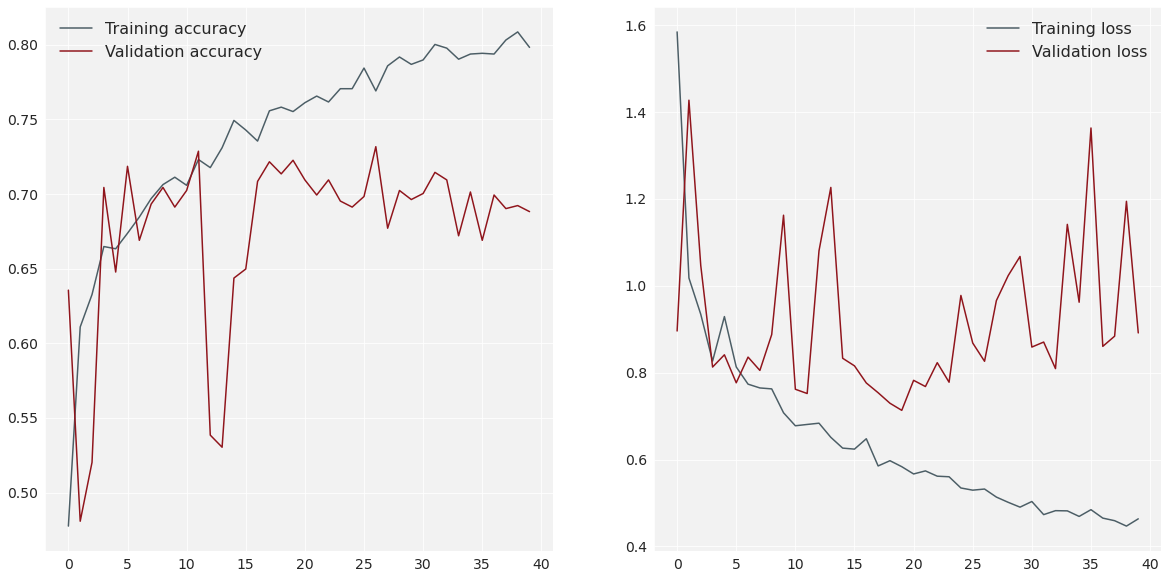

In [ ]:
sns.set_style("darkgrid", {"axes.facecolor": "0.95"})
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
epochs = range(len(history1.history['accuracy']))
sns.lineplot(epochs, history1.history['accuracy'], color='#4C5E66', label='Training accuracy', ax=ax1)
sns.lineplot(epochs, history1.history['val_accuracy'], color='#90151C', label='Validation accuracy', ax=ax1)
ax1.legend(frameon=False, fontsize=16)

sns.lineplot(epochs, history1.history['loss'], color='#4C5E66', label='Training loss', ax=ax2)
sns.lineplot(epochs, history1.history['val_loss'], color='#90151C', label='Validation loss', ax=ax2)
ax2.legend(frameon=False, fontsize=16)

plt.savefig('model1_learning_curves.png', format="png", bbox_inches='tight', dpi=300)   
plt.show();

#### Building Confusion Matrix


In [ ]:
Y_preds=model1.predict_generator(test_generator)
y_pred = np.argmax(Y_preds, axis=1)
Matrix1 = confusion_matrix(test_generator.classes, y_pred)
print(Matrix1)

[[122   0 181  21]
 [  6   0   3   0]
 [166   1 253  30]
 [ 75   3 114  13]]


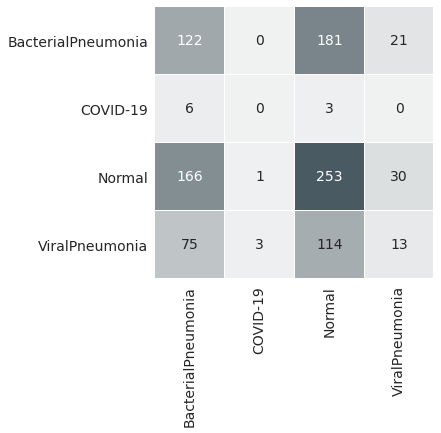

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
cmap = sns.light_palette("#4A5A62", as_cmap=True)
cm1 = sns.heatmap(Matrix1, annot=True, fmt="d", cbar=False, cmap=cmap, linewidths=0.01, ax=ax)
cm1.set_xticklabels(target_names, rotation = 90)
cm1.set_yticklabels(target_names, rotation = 0)
plt.savefig('model1_confusion_matrix.png', format="png", bbox_inches='tight', dpi=300)
plt.show();

#### Building Classification Report

In [ ]:
target_names = ['BacterialPneumonia', 'COVID-19', 'Normal', 'ViralPneumonia']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

                    precision    recall  f1-score   support

BacterialPneumonia       0.33      0.38      0.35       324
          COVID-19       0.00      0.00      0.00         9
            Normal       0.46      0.56      0.51       450
    ViralPneumonia       0.20      0.06      0.10       205

          accuracy                           0.39       988
         macro avg       0.25      0.25      0.24       988
      weighted avg       0.36      0.39      0.37       988



## Second Model

In [ ]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [ ]:
model2 = Sequential()

model2.add(Conv2D(16, (3,3), input_shape=(384,384,3), activation = "relu"))
model2.add(Conv2D(32, (3,3), activation = "relu"))
model2.add(Conv2D(64, (3,3), activation = "relu"))

model2.add(MaxPool2D(2,2))
model2.add(MaxPool2D(2,2))
model2.add(MaxPool2D(2,2))

model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(250, activation = "relu"))
model2.add(Dense(4, activation = "softmax"))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 382, 382, 16)      448       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 380, 380, 32)      4640      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 378, 378, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 189, 189, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 94, 94, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 47, 47, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 141376)           

In [ ]:
model2.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_generator, validation_data = test_generator, steps_per_epoch=64,epochs = 40, callbacks=[early_stopping], verbose = 1) 

Epoch 1/40
64/64 [==============================] - 86s 1s/step - loss: 1.5545 - accuracy: 0.4385 - val_loss: 1.1245 - val_accuracy: 0.6032
Epoch 2/40
64/64 [==============================] - 84s 1s/step - loss: 1.1224 - accuracy: 0.5873 - val_loss: 0.8625 - val_accuracy: 0.6377
Epoch 3/40
64/64 [==============================] - 84s 1s/step - loss: 0.9428 - accuracy: 0.6300 - val_loss: 0.8908 - val_accuracy: 0.6184
Epoch 4/40
64/64 [==============================] - 84s 1s/step - loss: 0.8554 - accuracy: 0.6601 - val_loss: 0.8020 - val_accuracy: 0.6903
Epoch 5/40
64/64 [==============================] - 83s 1s/step - loss: 0.8268 - accuracy: 0.6840 - val_loss: 0.8083 - val_accuracy: 0.7237
Epoch 6/40
64/64 [==============================] - 84s 1s/step - loss: 0.7897 - accuracy: 0.6798 - val_loss: 0.7962 - val_accuracy: 0.6781
Epoch 7/40
64/64 [==============================] - 84s 1s/step - loss: 0.7687 - accuracy: 0.6785 - val_loss: 0.8619 - val_accuracy: 0.6488
Epoch 8/40
64/64 [==

#### Visualization of learning curves

In [ ]:
history2_df = pd.DataFrame(history2.history)

print(("Best Validation Loss: {:0.4f}" + "\nBest Validation Accuracy: {:0.4f}").format(history2_df['val_loss'].min(), history2_df['val_accuracy'].max()))

Best Validation Loss: 0.7417
Best Validation Accuracy: 0.7480


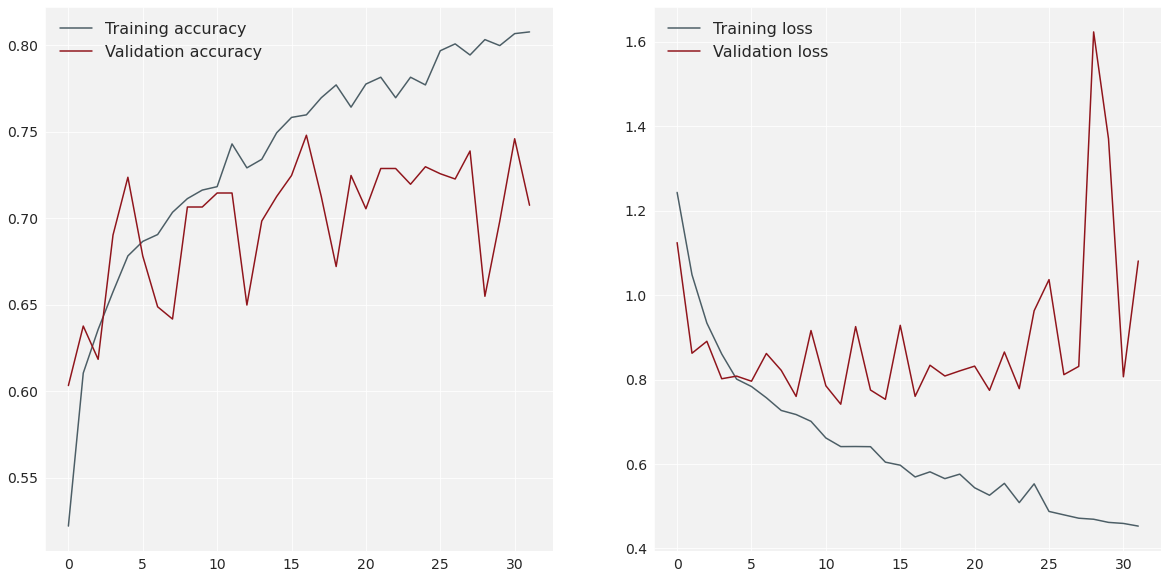

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
epochs = range(len(history2.history['accuracy']))
sns.lineplot(epochs, history2.history['accuracy'], color='#4C5E66', label='Training accuracy', ax=ax1)
sns.lineplot(epochs, history2.history['val_accuracy'], color='#90151C', label='Validation accuracy', ax=ax1)
ax1.legend(frameon=False, fontsize=16)

sns.lineplot(epochs, history2.history['loss'], color='#4C5E66', label='Training loss', ax=ax2)
sns.lineplot(epochs, history2.history['val_loss'], color='#90151C', label='Validation loss', ax=ax2)
ax2.legend(frameon=False, fontsize=16)

plt.savefig('model2_learning_curves.png', format="png", bbox_inches='tight', dpi=300)   
plt.show();

#### Building Confusion Matrix

In [ ]:
Y_preds=model2.predict_generator(test_generator)
y_pred = np.argmax(Y_preds, axis=1)
Matrix2 = confusion_matrix(test_generator.classes, y_pred)
print(Matrix2)

[[149   0 162  13]
 [  4   0   5   0]
 [191   1 232  26]
 [ 96   0 101   8]]


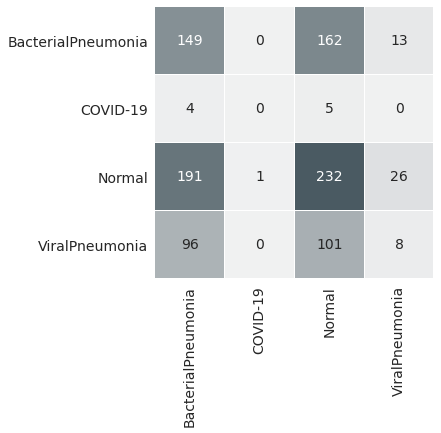

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
cm2 = sns.heatmap(Matrix2, annot=True, fmt="d", cbar=False, cmap=cmap, linewidths=0.01, ax=ax)
cm2.set_xticklabels(target_names, rotation = 90)
cm2.set_yticklabels(target_names, rotation = 0)
plt.savefig('model2_confusion_matrix.png', format="png", bbox_inches='tight', dpi=300)
plt.show();

#### Building Classification Report

In [ ]:
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

                    precision    recall  f1-score   support

BacterialPneumonia       0.34      0.46      0.39       324
          COVID-19       0.00      0.00      0.00         9
            Normal       0.46      0.52      0.49       450
    ViralPneumonia       0.17      0.04      0.06       205

          accuracy                           0.39       988
         macro avg       0.24      0.25      0.24       988
      weighted avg       0.36      0.39      0.36       988



## Third Model

In [ ]:
model3 = Sequential()

model3.add(Conv2D(16, (3,3), input_shape=(384,384,3), activation = "relu",  kernel_regularizer=l2(0.001)))
model3.add(Conv2D(32, (3,3), activation = "relu", kernel_regularizer=l2(0.001)))
model3.add(Conv2D(64, (3,3), activation = "relu", kernel_regularizer=l2(0.001)))

model3.add(MaxPool2D(2,2))
model3.add(MaxPool2D(2,2))
model3.add(MaxPool2D(2,2))

model3.add(Flatten())
model3.add(Dropout(0.5))
model3.add(Dense(64, activation = "relu"))
model3.add(Dense(4, activation = "softmax"))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 382, 382, 16)      448       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 380, 380, 32)      4640      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 378, 378, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 189, 189, 64)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 94, 94, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 47, 47, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 141376)           

In [ ]:
model3.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_generator, validation_data = test_generator, steps_per_epoch=64,epochs = 40, verbose = 1) 

Epoch 1/40
64/64 [==============================] - 87s 1s/step - loss: 2.4335 - accuracy: 0.3905 - val_loss: 1.0445 - val_accuracy: 0.5182
Epoch 2/40
64/64 [==============================] - 85s 1s/step - loss: 1.1446 - accuracy: 0.5709 - val_loss: 1.0944 - val_accuracy: 0.4990
Epoch 3/40
64/64 [==============================] - 85s 1s/step - loss: 1.2556 - accuracy: 0.5809 - val_loss: 0.9136 - val_accuracy: 0.6285
Epoch 4/40
64/64 [==============================] - 85s 1s/step - loss: 0.9928 - accuracy: 0.6343 - val_loss: 1.2006 - val_accuracy: 0.4049
Epoch 5/40
64/64 [==============================] - 85s 1s/step - loss: 0.9170 - accuracy: 0.6317 - val_loss: 0.9830 - val_accuracy: 0.5800
Epoch 6/40
64/64 [==============================] - 85s 1s/step - loss: 0.8695 - accuracy: 0.6584 - val_loss: 1.0608 - val_accuracy: 0.5374
Epoch 7/40
64/64 [==============================] - 85s 1s/step - loss: 0.8369 - accuracy: 0.6749 - val_loss: 1.0694 - val_accuracy: 0.6589
Epoch 8/40
64/64 [==

#### Visualization of learning curves

In [ ]:
history3_df = pd.DataFrame(history3.history)

print(("Best Validation Loss: {:0.4f}" + "\nBest Validation Accuracy: {:0.4f}").format(history3_df['val_loss'].min(), history3_df['val_accuracy'].max()))

Best Validation Loss: 0.7177
Best Validation Accuracy: 0.7379


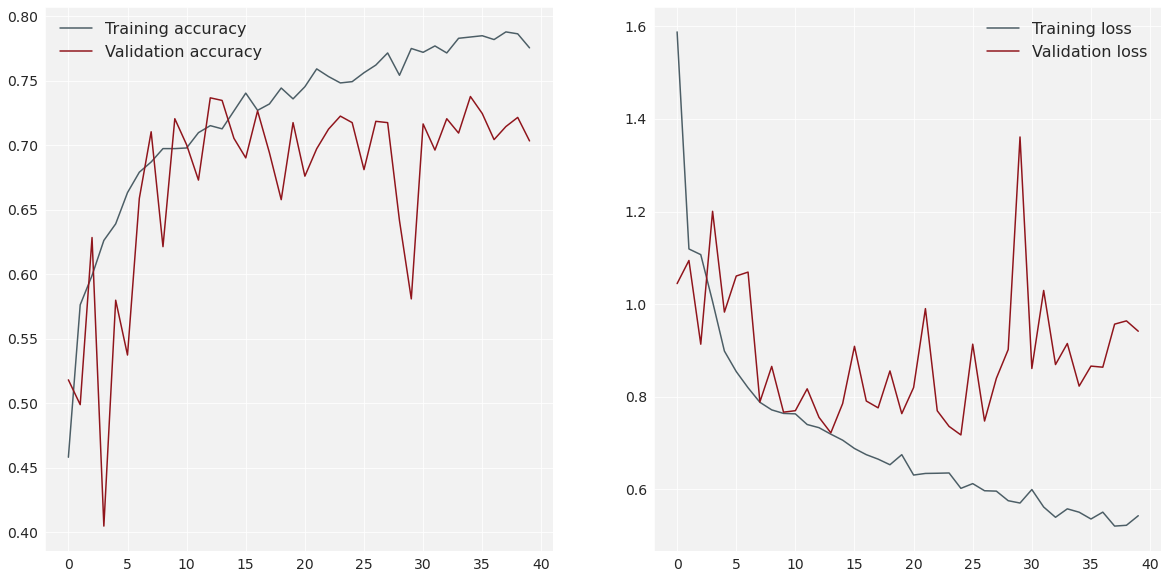

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
epochs = range(len(history3.history['accuracy']))
sns.lineplot(epochs, history3.history['accuracy'], color='#4C5E66', label='Training accuracy', ax=ax1)
sns.lineplot(epochs, history3.history['val_accuracy'], color='#90151C', label='Validation accuracy', ax=ax1)
ax1.legend(frameon=False, fontsize=16)

sns.lineplot(epochs, history3.history['loss'], color='#4C5E66', label='Training loss', ax=ax2)
sns.lineplot(epochs, history3.history['val_loss'], color='#90151C', label='Validation loss', ax=ax2)
ax2.legend(frameon=False, fontsize=16)

plt.savefig('model3_learning_curves.png', format="png", bbox_inches='tight', dpi=300)   
plt.show();

#### Building Confusion Matrix

In [ ]:
Y_preds=model3.predict_generator(test_generator)
y_pred = np.argmax(Y_preds, axis=1)
Matrix3 = confusion_matrix(test_generator.classes, y_pred)
print(Matrix3)

[[ 88   0 193  43]
 [  2   0   6   1]
 [125   2 286  37]
 [ 44   0 133  28]]


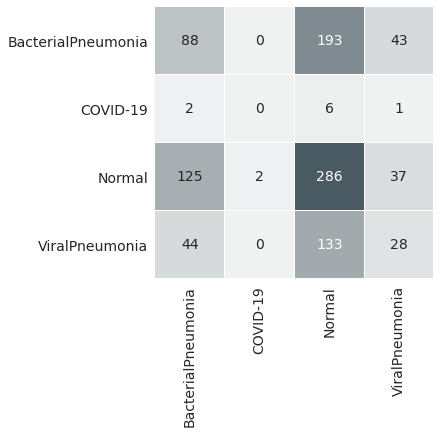

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
cmap = sns.light_palette("#4A5A62", as_cmap=True)
cm3 = sns.heatmap(Matrix3, annot=True, fmt="d", cbar=False, cmap=cmap, linewidths=0.01, ax=ax)
cm3.set_xticklabels(target_names, rotation = 90)
cm3.set_yticklabels(target_names, rotation = 0)
plt.savefig('model3_confusion_matrix.png', format="png", bbox_inches='tight', dpi=300)
plt.show();

#### Building Classification Report

In [ ]:
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

                    precision    recall  f1-score   support

BacterialPneumonia       0.34      0.27      0.30       324
          COVID-19       0.00      0.00      0.00         9
            Normal       0.46      0.64      0.54       450
    ViralPneumonia       0.26      0.14      0.18       205

          accuracy                           0.41       988
         macro avg       0.26      0.26      0.25       988
      weighted avg       0.38      0.41      0.38       988

